## Import library

In [26]:
# basic library
import numpy as np
import random, time

# agent
import tensorflow as tf
from tensorflow.keras import Model, layers
from collections import namedtuple, deque

# environment
import gym

# plot figure
import matplotlib.pyplot as plt

## Parameter

In [27]:
# environment
env_name = 'CartPole-v0'                       # environment name (gym)
env = gym.make(env_name)
num_actions = env.action_space.n               # dimension of action space
num_states = env.observation_space.shape[0]    # dimension of state space

# training agent
NUM_EPISODES = 10000                           # number of episodes for training
NUM_STEPS = env._max_episode_steps             # maximum number of steps for each episodes
GAMMA = 0.99                                   # discounted factor
TARGET_PERIOD = 1                              # copy network from model network to target network every N episode

# training Qnetwork
BATCH_SIZE = 32           # batch size for training network
lr = 1e-3                 # initial learning rate
lr_min = 1e-5             # minimum learning rate
lr_decay = 0.9            # learning rate decaying factor

# agent
CAPACITY = 10000          # size of replay memory
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'state_next', 'done'))

# result
print_period=100           # print arguments every N steps
foldername = 'result/'     # name of subfolder where result is stored

## Q-network

In [28]:
#Q-value network.
class DQN(Model):
    def __init__(self, num_states, num_actions):
        super(DQN, self).__init__()
        self.fc1 = layers.Dense(24, input_dim=num_states, activation='relu')
        self.fc2 = layers.Dense(24, activation='relu')
        self.fc3 = layers.Dense(num_actions, activation='linear')
        
        self.initialize(num_states)
    
    # predicts Q-values of each eaction
    def call(self, x):
        '''
            input  : (None, num_states)
            output : (None, num_actions)
        '''
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x   
    
    # initialize model
    def initialize(self, num_states):
        x = tf.keras.Input((num_states))
        return Model(inputs=[x], outputs=self.call(x))

#print network summary
a=DQN(num_states, num_actions)
a.initialize(num_states).summary()
del(a)

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_75 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_76 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_77 (Dense)             (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


## Agent

In [29]:
# DQN agent
class DQNagent(DQN):
    def __init__(self, num_states, num_actions):
        super(DQNagent, self).__init__(num_states, num_actions)
        self.num_states = num_states
        self.num_actions = num_actions
        self.memory = deque(maxlen=CAPACITY)
        self.epsilon = 1.0            # initial exploration rate
        self.epsilon_min = 0.01       # minimum exploration rate
        self.epsilon_decay = 0.95     # exploration rate decaying factor after training
        self.lr = lr                
        self.lr_min = lr_min
        self.lr_decay = lr_decay
        
        self.model = DQN(num_states, num_actions)         # model network : training network
        self.target = DQN(num_states, num_actions)        # target network
        self.loss_object = tf.losses.MeanSquaredError()   # loss function
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)   # optimizer for updating weights
    
    # return action by e-greedy
    def act(self, state, training=True):
        '''
            state : (num_states,)
            act_values : (1, num_actions)
            output : index
        '''
        if (random.random() <= self.epsilon) and training:
            return random.randrange(self.num_actions)
        act_values = self.model(state.reshape(1,-1))
        return np.argmax(act_values[0])  
    
    # memorize experience
    def memorize(self, state, action, reward, next_state, done):
        self.memory.append(Transition(state, action, reward, next_state, done))
    
    # replay experience 
    def train(self, batch_size):
        '''
            batch_state : (BATCH_SIZE, num_states)
            batch_action : (BATCH_SIZE,)
            batch_reward : (BATCH_SIZE,)
            batch_state_next : (BATCH_SIZE, num_states)
            batch_done : (BATCH_SIZE,)
            target : (BATCH_SIZE,) 
        '''
        batch = Transition(*zip(*random.sample(self.memory,batch_size)))
        
        batch_state = tf.stack(batch.state, axis=0)
        batch_action = tf.stack(batch.action, axis=0)
        batch_reward = tf.stack(batch.reward, axis=0)
        batch_state_next = tf.stack(batch.state_next, axis=0)  
        batch_done = tf.stack(batch.done, axis=0) 
            
        reward_done = reward
        reward_notdone = reward+GAMMA*tf.reduce_max(self.target(batch_state_next),axis=1)
        target = tf.where(batch_done, reward_done, reward_notdone)
        
        # compute gradient
        with tf.GradientTape() as tape:
            tape.watch(self.model.trainable_variables)
            predict = tf.multiply(self.model(batch_state), tf.one_hot(batch_action, depth=self.num_actions))
            predict = tf.reduce_sum(predict, axis=1)            
            loss = self.loss_object(target, predict)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    # copy network
    def target_update(self):
        self.target.set_weights(self.model.get_weights())        
    
    # learning rate decaying
    def lr_decaying(self):
        if self.lr>self.lr_min:
            self.lr = self.lr*self.lr_decay
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
    
    # epsilon decaying
    def epsilon_decaying(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay        
    
    # save network weights
    def save_model(self, fname):
        self.model.save_weights(fname, overwrite=True)
        
    # load network weights
    def load_model(self, fname):
        self.model.load_weights(fname)

## Training

In [35]:
agent = DQNagent(num_states, num_actions)
done = False

T=time.time()
score_plot = []
best_mean_score = -np.inf
best_score = 180

for epi in range(NUM_EPISODES):
    state = env.reset()
    state = state.astype(np.float32)
        
    for step in range(NUM_STEPS):
        action = agent.act(state)
        state_next, reward, done, _ = env.step(action)
        state_next = state_next.astype(np.float32)
        reward = reward if not done else -10
        agent.memorize(state, action, reward, state_next, done)
        state = state_next

        if len(agent.memory)>BATCH_SIZE:
            agent.train(BATCH_SIZE)   
            
        if done:         
            break
    agent.epsilon_decaying()
    score = step
    
    # compute score
    score_plot.append(score)
    mean_score = np.mean(score_plot[-100:])   # mean score of recent 100 episodes
    
    # learning rate decaying
    if score>=best_score:
        best_score = score
        agent.lr_decaying()
    
    # copy network
    if epi%TARGET_PERIOD==0:
        agent.target_update()
    
    # print
    if epi%print_period==0:
        print("episode: %.4d/%.4d, score: %.3d, mean score: %.3d, lr: %.1e, e: %.2f, time: %.2f" 
              %(epi, NUM_EPISODES-1, score, mean_score, agent.lr, agent.epsilon, time.time()-T))  
                
    # save network
    if mean_score>best_mean_score:
        best_mean_score = mean_score
        fname = foldername+'best_network.h5'
        agent.save_model(fname)
        print("episode: %.4d/%.4d, score: %.3d, mean score: %.3d, lr: %.1e, e: %.2f, time: %.2f" 
              %(epi, NUM_EPISODES-1, score, mean_score, agent.lr, agent.epsilon, time.time()-T))    
        print("SAVE : ", fname)
           

episode: 0000/9999, score: 018, mean score: 018, lr: 1.0e-03, e: 0.95, time: 0.00
episode: 0000/9999, score: 018, mean score: 018, lr: 1.0e-03, e: 0.95, time: 0.01
SAVE :  result/best_network.h5
episode: 0001/9999, score: 020, mean score: 019, lr: 1.0e-03, e: 0.90, time: 0.09
SAVE :  result/best_network.h5
episode: 0002/9999, score: 031, mean score: 023, lr: 1.0e-03, e: 0.86, time: 0.28
SAVE :  result/best_network.h5
episode: 0100/9999, score: 009, mean score: 010, lr: 1.0e-03, e: 0.01, time: 7.78
episode: 0200/9999, score: 011, mean score: 009, lr: 1.0e-03, e: 0.01, time: 15.26
episode: 0300/9999, score: 011, mean score: 009, lr: 1.0e-03, e: 0.01, time: 22.78
episode: 0400/9999, score: 008, mean score: 009, lr: 1.0e-03, e: 0.01, time: 30.42
episode: 0500/9999, score: 009, mean score: 009, lr: 1.0e-03, e: 0.01, time: 37.72
episode: 0600/9999, score: 011, mean score: 010, lr: 1.0e-03, e: 0.01, time: 45.54
episode: 0700/9999, score: 017, mean score: 011, lr: 1.0e-03, e: 0.01, time: 53.95

episode: 2870/9999, score: 088, mean score: 041, lr: 9.0e-04, e: 0.01, time: 259.13
SAVE :  result/best_network.h5
episode: 2871/9999, score: 090, mean score: 042, lr: 9.0e-04, e: 0.01, time: 259.74
SAVE :  result/best_network.h5
episode: 2872/9999, score: 110, mean score: 043, lr: 9.0e-04, e: 0.01, time: 260.48
SAVE :  result/best_network.h5
episode: 2873/9999, score: 108, mean score: 044, lr: 9.0e-04, e: 0.01, time: 261.21
SAVE :  result/best_network.h5
episode: 2874/9999, score: 159, mean score: 045, lr: 9.0e-04, e: 0.01, time: 262.31
SAVE :  result/best_network.h5
episode: 2875/9999, score: 107, mean score: 046, lr: 9.0e-04, e: 0.01, time: 263.08
SAVE :  result/best_network.h5
episode: 2876/9999, score: 089, mean score: 047, lr: 9.0e-04, e: 0.01, time: 263.69
SAVE :  result/best_network.h5
episode: 2877/9999, score: 131, mean score: 048, lr: 9.0e-04, e: 0.01, time: 264.58
SAVE :  result/best_network.h5
episode: 2878/9999, score: 179, mean score: 049, lr: 9.0e-04, e: 0.01, time: 265

episode: 2942/9999, score: 131, mean score: 128, lr: 2.1e-04, e: 0.01, time: 333.76
SAVE :  result/best_network.h5
episode: 2943/9999, score: 107, mean score: 128, lr: 2.1e-04, e: 0.01, time: 334.50
SAVE :  result/best_network.h5
episode: 2944/9999, score: 121, mean score: 129, lr: 2.1e-04, e: 0.01, time: 335.33
SAVE :  result/best_network.h5
episode: 2946/9999, score: 124, mean score: 130, lr: 2.1e-04, e: 0.01, time: 336.96
SAVE :  result/best_network.h5
episode: 2947/9999, score: 119, mean score: 131, lr: 2.1e-04, e: 0.01, time: 337.76
SAVE :  result/best_network.h5
episode: 2948/9999, score: 111, mean score: 131, lr: 2.1e-04, e: 0.01, time: 338.53
SAVE :  result/best_network.h5
episode: 2949/9999, score: 123, mean score: 132, lr: 2.1e-04, e: 0.01, time: 339.36
SAVE :  result/best_network.h5
episode: 2950/9999, score: 127, mean score: 133, lr: 2.1e-04, e: 0.01, time: 340.21
SAVE :  result/best_network.h5
episode: 2951/9999, score: 107, mean score: 134, lr: 2.1e-04, e: 0.01, time: 340

episode: 3902/9999, score: 131, mean score: 151, lr: 9.7e-06, e: 0.01, time: 1159.54
SAVE :  result/best_network.h5
episode: 3904/9999, score: 199, mean score: 151, lr: 9.7e-06, e: 0.01, time: 1161.80
SAVE :  result/best_network.h5
episode: 3905/9999, score: 199, mean score: 152, lr: 9.7e-06, e: 0.01, time: 1163.22
SAVE :  result/best_network.h5
episode: 3906/9999, score: 179, mean score: 152, lr: 9.7e-06, e: 0.01, time: 1164.45
SAVE :  result/best_network.h5
episode: 3908/9999, score: 199, mean score: 153, lr: 9.7e-06, e: 0.01, time: 1166.72
SAVE :  result/best_network.h5
episode: 3910/9999, score: 199, mean score: 153, lr: 9.7e-06, e: 0.01, time: 1168.96
SAVE :  result/best_network.h5
episode: 3913/9999, score: 199, mean score: 154, lr: 9.7e-06, e: 0.01, time: 1172.20
SAVE :  result/best_network.h5
episode: 3914/9999, score: 129, mean score: 154, lr: 9.7e-06, e: 0.01, time: 1173.11
SAVE :  result/best_network.h5
episode: 3915/9999, score: 124, mean score: 154, lr: 9.7e-06, e: 0.01, t

episode: 4080/9999, score: 199, mean score: 176, lr: 9.7e-06, e: 0.01, time: 1365.98
SAVE :  result/best_network.h5
episode: 4082/9999, score: 199, mean score: 177, lr: 9.7e-06, e: 0.01, time: 1368.64
SAVE :  result/best_network.h5
episode: 4083/9999, score: 199, mean score: 178, lr: 9.7e-06, e: 0.01, time: 1370.01
SAVE :  result/best_network.h5
episode: 4084/9999, score: 199, mean score: 178, lr: 9.7e-06, e: 0.01, time: 1371.41
SAVE :  result/best_network.h5
episode: 4085/9999, score: 199, mean score: 179, lr: 9.7e-06, e: 0.01, time: 1372.79
SAVE :  result/best_network.h5
episode: 4087/9999, score: 199, mean score: 179, lr: 9.7e-06, e: 0.01, time: 1375.17
SAVE :  result/best_network.h5
episode: 4088/9999, score: 199, mean score: 180, lr: 9.7e-06, e: 0.01, time: 1376.57
SAVE :  result/best_network.h5
episode: 4093/9999, score: 199, mean score: 180, lr: 9.7e-06, e: 0.01, time: 1383.48
SAVE :  result/best_network.h5
episode: 4094/9999, score: 199, mean score: 181, lr: 9.7e-06, e: 0.01, t

KeyboardInterrupt: 

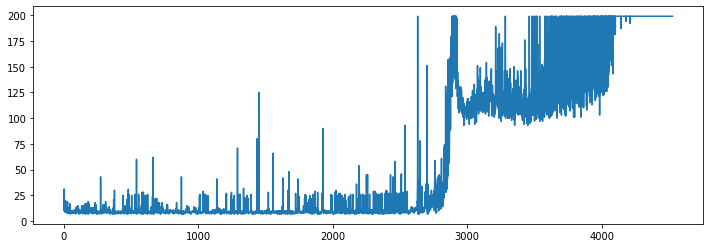

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
ax.plot(score_plot)
plt.savefig(foldername+'score_train.png') 

## Test

In [38]:
agent = DQNagent(num_states, num_actions)
fname = foldername+'best_network.h5'
agent.load_model(fname)
print("LOAD : ", fname, "\n")
done = False
T=time.time()
score_plot = []

TEST_NUM_EPISODES=100
for epi in range(TEST_NUM_EPISODES):
    state = env.reset()
    state = state.astype(np.float32)
        
    for step in range(NUM_STEPS):
        action = agent.act(state, training=False)
        state_next, reward, done, _ = env.step(action)
        state_next = state_next.astype(np.float32)
        state = state_next
        if done:
            print("episode: %.3d/%.3d, score: %.3d, time: %.2f" 
                    %(epi, TEST_NUM_EPISODES, step, time.time()-T))           
            break        
    
    score_plot.append(step)
    
env.close()

LOAD :  result/best_network.h5 

episode: 000/100, score: 199, time: 0.21
episode: 001/100, score: 199, time: 0.38
episode: 002/100, score: 199, time: 0.55
episode: 003/100, score: 199, time: 0.73
episode: 004/100, score: 199, time: 0.90
episode: 005/100, score: 199, time: 1.08
episode: 006/100, score: 199, time: 1.25
episode: 007/100, score: 199, time: 1.42
episode: 008/100, score: 199, time: 1.60
episode: 009/100, score: 199, time: 1.77
episode: 010/100, score: 199, time: 1.94
episode: 011/100, score: 199, time: 2.11
episode: 012/100, score: 199, time: 2.29
episode: 013/100, score: 199, time: 2.46
episode: 014/100, score: 199, time: 2.63
episode: 015/100, score: 199, time: 2.80
episode: 016/100, score: 199, time: 2.98
episode: 017/100, score: 199, time: 3.15
episode: 018/100, score: 199, time: 3.32
episode: 019/100, score: 199, time: 3.50
episode: 020/100, score: 199, time: 3.67
episode: 021/100, score: 199, time: 3.84
episode: 022/100, score: 199, time: 4.01
episode: 023/100, score:

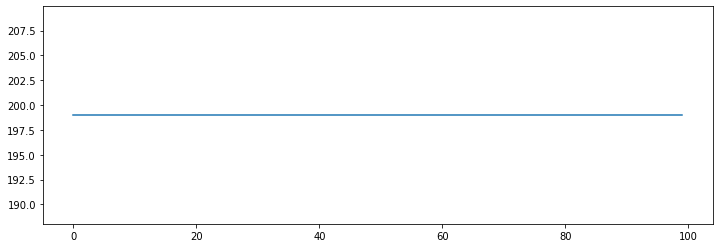

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
ax.plot(score_plot)
plt.savefig(foldername+'score_test.png')  